# Magnetic Reconnection

This notebook outlines a data processing pipeline for accessing, transforming and analysing IMF vectors to find out the frequency of magnetic reconnection occuring.


## 0. Setup
Basic libraries for data representation and processing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cdflib

### CDAS Web Service
We use the `cdasws` library to download datasets from the Coordinated Data Analysis remote server.

In [2]:
from cdasws import CdasWs

cdas = CdasWs()

### Dataset-defining constants

In [3]:
data_source = "AC_H2_MFI"  # ACE Level 2 hourly data
time_start = "2000-01-01T00:00:00.000Z"  # Start of analysis
time_end = "2021-01-01T00:00:00.000Z"  # End of analysis

### Utility for dataset loading

In [4]:
# Downloads dataset using cdasws
def get_dataset(source, variables, start, end):
    res = cdas.get_data(dataset=source, variables=variables, time0=start, time1=end)
    status = res[0]
    data = res[1]

    if status["http"]["status_code"] != 200:
        print("ERR: Download from dataset server failed!")
        return

    return data

## 1. Start of pipeline: download data
We only require the Bx, By and Bz variables for our analysis. Although the coordinate systems differ, the X axis in both GSE and GSM is the same so we can simply keep Bx in GSE while using converted By and Bz.

In [5]:
ds = get_dataset(data_source, ["BGSM"], time_start, time_end)

/Users/cat/anaconda3/envs/mrec/lib/python3.11/site-packages/cdflib/xarray/cdf_to_xarray.py:619: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  created_vars[var_name] = xr.Variable(var_dims, var_data, attrs=var_atts)  # type: ignore[no-untyped-call]


- Editorial note: The warning above is an issue with the cdflib package that is used to transform NASA CDFs to xarray datasets.

## 2. Transformation of data

In [6]:
ds = ds["BGSM"]

row_x = ds[:, 0].to_dataframe().drop('cartesian', axis=1).drop('metavar0', axis=1)
row_y = ds[:, 1].to_dataframe().drop('cartesian', axis=1).drop('metavar0', axis=1)
row_z = ds[:, 2].to_dataframe().drop('cartesian', axis=1).drop('metavar0', axis=1)

da_x = xr.DataArray(row_x['BGSM'], dims='Epoch', coords={'Epoch': row_x.index})
da_y = xr.DataArray(row_y['BGSM'], dims='Epoch', coords={'Epoch': row_y.index})
da_z = xr.DataArray(row_z['BGSM'], dims='Epoch', coords={'Epoch': row_z.index})

ds_transformed = xr.Dataset({
    'x': da_z,
    'y': da_y,
    'z': da_z
})

Demonstration of transformation (run before and after):

In [7]:
ds_transformed

<xarray.Dataset>
Dimensions:  (Epoch: 184105)
Coordinates:
  * Epoch    (Epoch) datetime64[ns] 2000-01-01 ... 2021-01-01
Data variables:
    x        (Epoch) float32 -0.937 -2.437 -1.637 -1.869 ... 0.968 1.202 1.171
    y        (Epoch) float32 3.697 5.406 4.803 2.184 ... -0.465 -1.023 -2.311
    z        (Epoch) float32 -0.937 -2.437 -1.637 -1.869 ... 0.968 1.202 1.171

## 2. Reconnection detection function
Through our research we understood that in an envrionment modeled around Earth's magnetosphere, reconnection occurs in 2 places:
- Primary reconnection of "-Z"-facing IMFs with "+Z" closed magnetic fields 
- Reconnection of open fields in the magnetotail caused by fields being pushed by solar winds
In an analysis of IMFs at Lagrange point 1, we can capture primary reconnections occuring.

### Applying detection function to dataset

In [8]:
threshold = ds_transformed.z.mean() - ds_transformed.std() * 2

ds_transformed_filtered = ds_transformed.where(ds_transformed.z < threshold, drop=True)

## 3. Visualization of reconnection occurences

### Plot of Bz over time

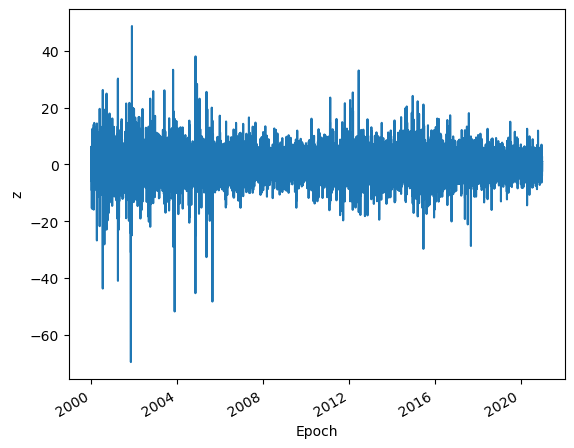

In [9]:
ds_transformed.z.plot()

### Frequency of extreme negative field magnitudes

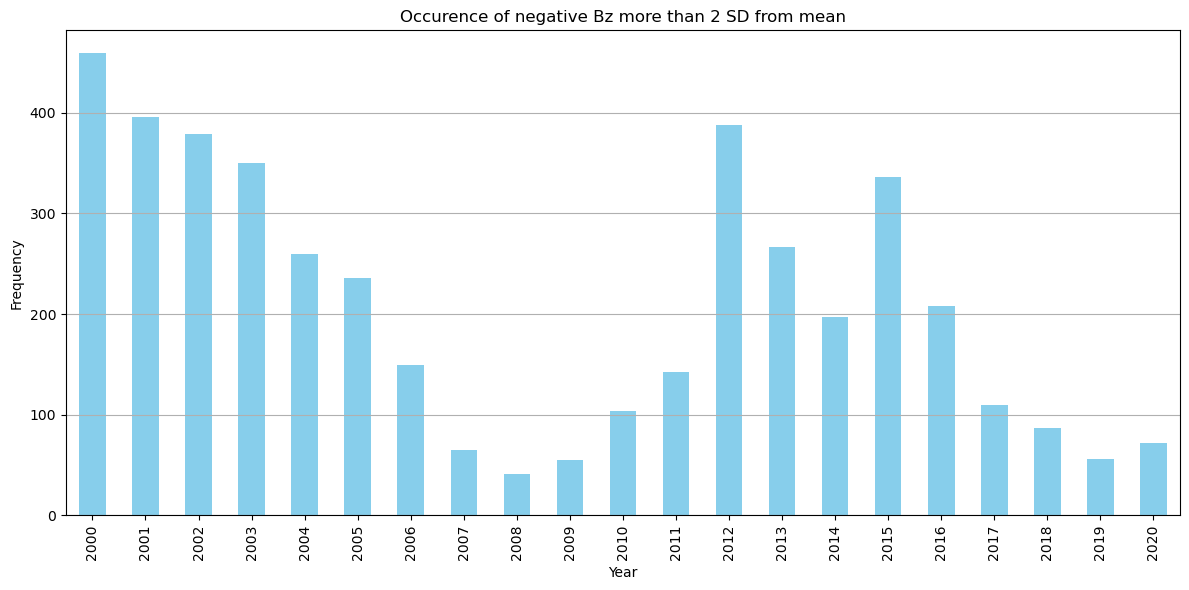

In [10]:
event_times = ds_transformed_filtered['Epoch']

# Convert the event_times to a Pandas DataFrame for easier manipulation
event_df = event_times.to_dataframe()

# Extract the year component for grouping
event_df['year'] = event_df.index.year

# Calculate the frequency of event occurrences by grouping by year
event_frequency = event_df.groupby('year').size()

# Create a plot to show how often the event occurs over the years
plt.figure(figsize=(12, 6))
event_frequency.plot(kind='bar', color='skyblue')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Occurence of negative Bz more than 2 SD from mean')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()